In [1]:
# Show the correlation between real and predicted tuning curves
import os
parent_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
grandparent_directory = os.path.abspath(os.path.join(parent_directory, os.pardir))
os.sys.path.append(grandparent_directory)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from scipy.stats import pearsonr

from tools.data_formatting import get_smoothed_moving_all_data, get_common_indexes_n_recordings, smooth_tuning_curves_circularly, from_local_to_global_index
from tools.data_manager import get_all_experiments_runs, get_fovs_given_animal
from tools.alignment import procrustes, canoncorr
from params import order_experiments, get_colors_for_each_experiment, animals, root_dir, experiments_to_exclude

# Load the data

In [2]:
### Load all sessions ###

animal = 'm135'
fov = 'fov1'
sessions = get_all_experiments_runs(animal, fov)
# Remove sessions to exclude
sessions = [session for session in sessions if session not in experiments_to_exclude]
# Create a mapping of sessions and their chronological order
order_map = {value: index for index, value in enumerate(order_experiments)}
sessions = sorted(sessions, key=lambda x: order_map[x])

# Load the cells with the global index and the tuning curves
all_cells = []
all_tuning_curves = []
for (experiment, run) in sessions:
    _, _, phi, cells, tuning_curves, _ = get_smoothed_moving_all_data(animal, fov, experiment, run)
    cells = from_local_to_global_index(animal, fov, (experiment, run), cells)
    all_cells.append(cells)
    all_tuning_curves.append(tuning_curves)

# Using the first session as the predictor, I look at the profile of tuning curves after the alignment of the neurons when included vs. excluded from the alignment

In [41]:
### Align the tuning curves to a reference session ###

# Smooth the tuning curves very little for better alignment
smoothed_tuning_curves = [smooth_tuning_curves_circularly(tuning_curves, 5) for tuning_curves in all_tuning_curves]
# Take the first session as the reference
ref = 0
exp0, run0 = sessions[ref]
ref_avg_fr = smoothed_tuning_curves[ref]
ref_cells = all_cells[ref]


# Find the predicted tuning curves using one session as reference, using all the neurons

pca = PCA(n_components=20) # Use 20 as it is around 80% of the variance
pca_ref_tc = pca.fit_transform(ref_avg_fr)
# Transform all the other tuning curves to the reference
predicted_tuning_curves_all_neruons = [] # ref session onto the other session
for i in range(len(sessions)-1):
    # Get the session to align to
    tuning_curves = smoothed_tuning_curves[i+1]
    # Get common neurons with reference session
    cells_masks, ordered_cells, common_neurons = get_common_indexes_n_recordings([ref_cells, all_cells[i+1]])
    # Align the tuning curves
    pca_tc = pca.fit_transform(tuning_curves)
    pca_components = pca.components_
    pca_means = np.mean(tuning_curves, axis=0)
    # Align using all neurons
    _, B, _, ref_cca_tc, _ = canoncorr(pca_ref_tc, pca_tc, fullReturn=True)
    # Calculate the predicted tuning curves
    predicted_tc = (ref_cca_tc @ np.linalg.inv(B) @ pca_components) + pca_means
    # Only keep the neurons that are common to both sessions
    predicted_tc = predicted_tc[:, cells_masks[1]]
    predicted_tc = predicted_tc[:, ordered_cells[1]]
    predicted_tuning_curves_all_neruons.append(predicted_tc)

# Keep one neuron out of the alignment, but still find its tuning curve
predicted_tuning_curves_one_out = []
for i in range(len(sessions)-1):
    # Get the session to align to
    tuning_curves = smoothed_tuning_curves[i+1]
    pca.fit_transform(tuning_curves)
    components = pca.components_
    # Get common neurons with reference session
    cells_masks, ordered_cells, common_neurons = get_common_indexes_n_recordings([ref_cells, all_cells[i+1]])
    # For each neuron, exclude it and then align
    tuning_curves_kept_out = []
    for n in range(len(common_neurons)):
        idx_to_remove_ref = np.arange(ref_avg_fr.shape[1])[cells_masks[0]][ordered_cells[0]][n]
        idx_to_remove = np.arange(tuning_curves.shape[1])[cells_masks[1]][ordered_cells[1]][n]
        sel_tc_ref = np.delete(ref_avg_fr, idx_to_remove_ref, axis=1)
        sel_tc = np.delete(tuning_curves, idx_to_remove, axis=1)
        sel_tc_ref_PCA = pca.fit_transform(sel_tc_ref)
        sel_tc_PCA = pca.fit_transform(sel_tc)
        A, B, _, _, _ = canoncorr(sel_tc_ref_PCA, sel_tc_PCA, fullReturn=True)
        # Predicted tuning curves using the alignment and all the neurons
        predicted_tc = pca_ref_tc @ A @ np.linalg.inv(B) @ components + np.mean(tuning_curves, axis=0)
        tuning_curves_kept_out.append(predicted_tc[:, idx_to_remove])
    tuning_curves_kept_out = np.array(tuning_curves_kept_out)
    predicted_tuning_curves_one_out.append(tuning_curves_kept_out.T)

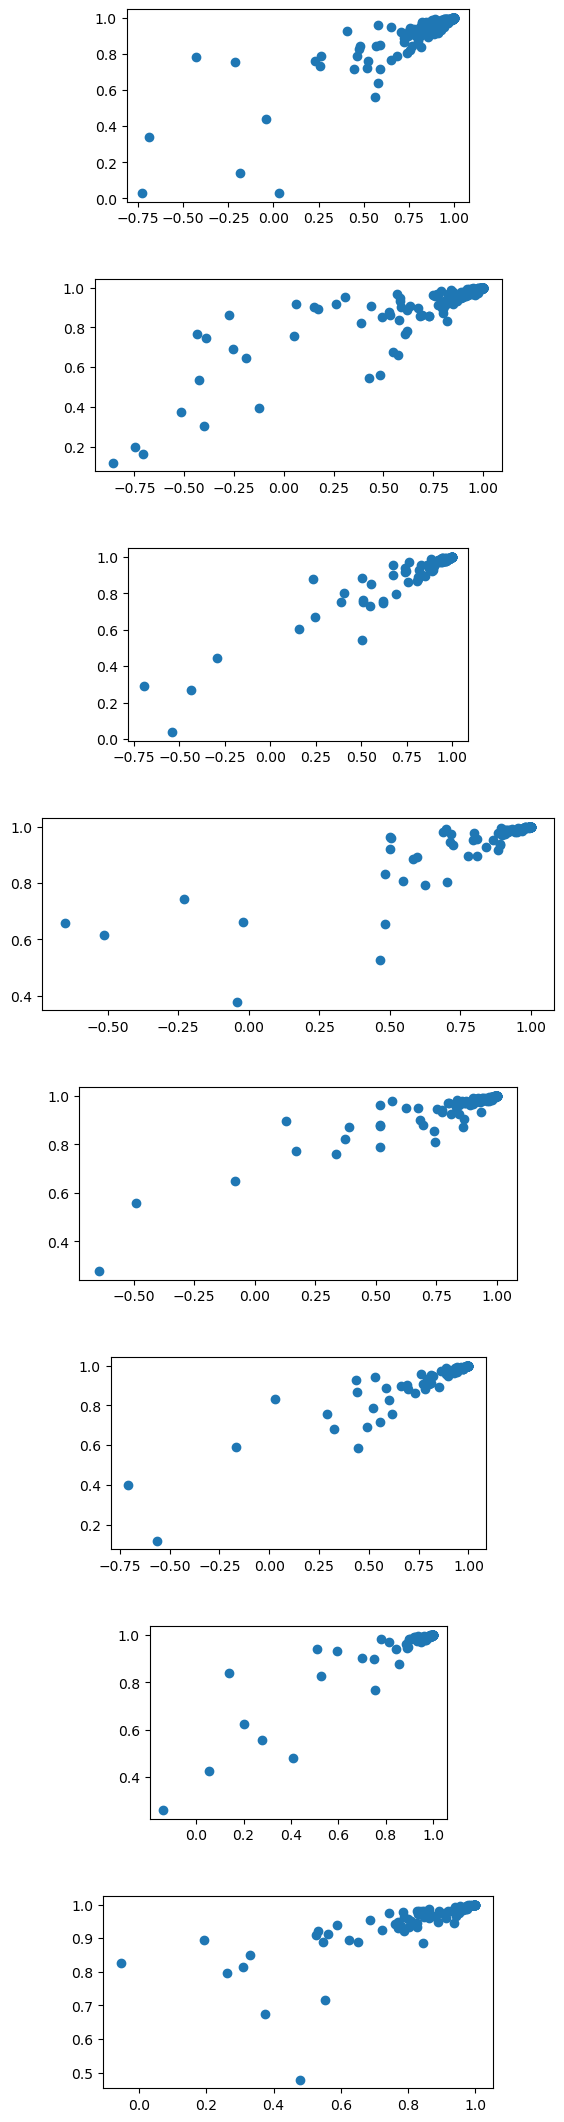

In [43]:
# Plot the difference between the predicted tunign curves with and without the neuron kept out

### Plot the correlation, cosine similarity, R2 between real and predicted tuning curves ###

fig = plt.figure(figsize=(10, 3*len(sessions)))
grid = plt.GridSpec(nrows=len(sessions)-1, ncols=1, figure=fig, wspace=0.4, hspace=0.4)
colors = get_colors_for_each_experiment(sessions[1:])
for i, (exp, run) in enumerate(sessions[1:]):
    # Where to save the metrics for this session
    correlations_aligned, correlations_not_aligned = [], []
    cosine_similarities_aligned, cosine_similarities_not_aligned = [], []
    r2_aligned, r2_not_aligned = [], []
    for n in range(predicted_tuning_curves_all_neruons[i].shape[1]):
        # Only if none of them is completely flat
        if (not np.all(predicted_tuning_curves_all_neruons[i][:, n] == predicted_tuning_curves_all_neruons[i][0, n])) and (not np.all(predicted_tuning_curves_one_out[i][:, n] == predicted_tuning_curves_one_out[i][0, n])):
            # After alignment
            correlations_aligned.append(pearsonr(predicted_tuning_curves_all_neruons[i][:, n], predicted_tuning_curves_one_out[i][:, n])[0])
            cosine_similarities_aligned.append(np.dot(predicted_tuning_curves_all_neruons[i][:, n], predicted_tuning_curves_one_out[i][:, n]) / (np.linalg.norm(predicted_tuning_curves_all_neruons[i][:, n]) * np.linalg.norm(predicted_tuning_curves_one_out[i][:, n])))
            r2_aligned.append(np.linalg.norm(predicted_tuning_curves_all_neruons[i][:, n] - predicted_tuning_curves_one_out[i][:, n])**2)

    # Plot correlation
    ax = fig.add_subplot(grid[i, 0])
    ax.scatter(correlations_aligned, cosine_similarities_aligned)
    ax.set_aspect('equal', adjustable='box')
